Introduction to machine learning with PyTorch - Part II
---


=============================================

----

**Note:** This notebook covers the following:


	1.	Understanding autograd for automatic differentiation.
	2.	Applying gradient descent for optimization.
	3.	Classification of Fashion MNIST using linear layers.
	4.	A brief introduction to CNNs(Convolutional Neural Networks).
	5.	Fundamental mathematical principles of deep learning through three hands-on examples.

# 3. Mini-batching

In this section, we will deal with a problem in which the input data has multiple features for each datapoint. In addition, we will introduce the concept of batch training.


In previous examples, we've shown models' capability of fitting to data on which the models are trained. Yet, in real-life scenarios, we want our models to perform well on data that they **never saw before**.

The **train/test/validation** split is a fundamental technique used to evaluate and optimize predictive models. The process involves dividing the available data into three distinct subsets: the training set, the validation set, and the test set.

- Training set: train the model by allowing it to learn patterns and relationships from the input data.
- Validation set: data for model selection and fine-tuning the model's hyperparameters.
- Test set: evaluate the model's performance on unseen data, providing an unbiased estimate of its generalization ability.


In [ ]:
!pip install gif
!wget https://raw.githubusercontent.com/qzheng75/PyTorch-bootcamp/main/1-Lecture-one-files/gif_utils.py
! pip install graphviz
import gif_utils
import gif
from IPython.display import Image, display

--2024-07-25 20:07:40--  https://raw.githubusercontent.com/qzheng75/PyTorch-bootcamp/main/1-Lecture-one-files/gif_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1591 (1.6K) [text/plain]
Saving to: ‘gif_utils.py’

gif_utils.py        100%[===================>]   1.55K  --.-KB/s    in 0s      

2024-07-25 20:07:40 (26.4 MB/s) - ‘gif_utils.py’ saved [1591/1591]



##NOTE: Before starting this notebook we need to include gpu.To do that go to   Runtime -> Change runtime type and select T4 GPU

In [ ]:
import torch
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the Auto MPG dataset
data = fetch_openml(name='autoMpg', version=3, parser='auto')
X = data.data
y = data.target

In [ ]:
X

,Displacement,Horse_power,Weight,Acceleration,Model_year
0,91.0,70,1955,20.5,71
1,232.0,100,2789,15.0,73
2,350.0,145,4055,12.0,76
3,318.0,140,4080,13.7,78
4,113.0,95,2372,15.0,70
...,...,...,...,...,...
387,225.0,105,3121,16.5,73
388,454.0,220,4354,9.0,70
389,85.0,65,1975,19.4,81
390,350.0,165,3693,11.5,70


In [ ]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((235, 5), (78, 5), (79, 5), (235,), (78,), (79,))

In [ ]:
X_train

,Displacement,Horse_power,Weight,Acceleration,Model_year
210,140.0,83,2639,17.0,75
342,122.0,96,2300,15.5,77
323,400.0,167,4906,12.5,73
89,120.0,75,2542,17.5,80
244,98.0,83,2075,15.9,77
...,...,...,...,...,...
71,79.0,67,1950,19.0,74
106,163.0,125,3140,13.6,78
270,90.0,70,1937,14.0,75
348,225.0,100,3233,15.4,76


In [ ]:
# Standard scaling makes training stabler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
X_train = scaler.fit_transform(X_train) # We get mean and std from only train data
X_val = scaler.transform(X_val) # And then apply that transformation to validation and test
X_test = scaler.transform(X_test)

In [ ]:
# Turn numpy arrays to torch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

In [ ]:
X_train

tensor([[-0.4765, -0.5215, -0.3545,  0.5425, -0.3186],
        [-0.6558, -0.1688, -0.7645, -0.0366,  0.2239],
        [ 2.1135,  1.7577,  2.3874, -1.1950, -0.8611],
        ...,
        [-0.9746, -0.8743, -1.2036, -0.6158, -0.3186],
        [ 0.3702, -0.0603,  0.3639, -0.0753, -0.0473],
        [ 0.4300,  0.0754,  0.5961,  0.5039,  0.2239]])

In [ ]:
torch.mean(X_train, dim=0), torch.std(X_train, dim=0),

(tensor([ 6.5946e-09,  6.0873e-09,  0.0000e+00,  7.1018e-09, -2.0291e-09]),
 tensor([1.0021, 1.0021, 1.0021, 1.0021, 1.0021]))

In [ ]:
# Define a more customized MLP model
from torch import nn

class MLP(nn.Module):
  def __init__(self, input_dim=1, hidden_dims=None, output_dim=1):
    super(MLP, self).__init__()

    if hidden_dims is None:
      hidden_dims = [32, 32]

    layers = []
    dims = [input_dim] + hidden_dims + [output_dim]

    for i in range(len(dims) - 1):
      layers.append(nn.Linear(dims[i], dims[i+1]))
      if i < len(dims) - 2:
        layers.append(nn.ReLU())

    self.mlp = nn.Sequential(*layers)

  def forward(self, X):
    return self.mlp(X)

In [ ]:
net = MLP(input_dim=5, hidden_dims=[16, 32, 32])
# Push model parameters onto GPU
if torch.cuda.is_available():
  net = net.cuda()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

## Why mini-batching?

In our previous example, we do the forward pass on the full dataset `X` and use the loss computed to update model parameters. This is good for a small dataset, but may be impossible for larger dataset.

Mini-batching in machine learning involves processing small, random subsets of the training data in each iteration, rather than the entire dataset at once.

This approach offers two benefits:
- It reduces memory usage, allowing you to work with larger datasets that might not fit into memory all at once.
- It speeds up the learning process by updating the model more frequently.

In PyTorch, mini-batching can be performed easily with loading your data first into `Dataset` object then into `DataLoader` object. You can then access the batches in a loop.


In [ ]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
# Create dataloaders to turn data into batches
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for idx, (X, y) in enumerate(train_loader):
  print(f"Batch {idx}: X has shape: {X.shape}, y has shape {y.shape}")

Batch 0: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 1: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 2: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 3: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 4: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 5: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 6: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 7: X has shape: torch.Size([11, 5]), y has shape torch.Size([11, 1])


New best model at epoch 0 with training loss 386.908 and validation loss 80.924
New best model at epoch 1 with training loss 62.503 and validation loss 23.936
New best model at epoch 3 with training loss 24.546 and validation loss 16.272
New best model at epoch 4 with training loss 13.359 and validation loss 12.293
New best model at epoch 6 with training loss 10.840 and validation loss 7.747
New best model at epoch 9 with training loss 9.565 and validation loss 6.999
New best model at epoch 11 with training loss 8.360 and validation loss 6.713
New best model at epoch 25 with training loss 8.546 and validation loss 6.480
New best model at epoch 41 with training loss 8.051 and validation loss 6.181


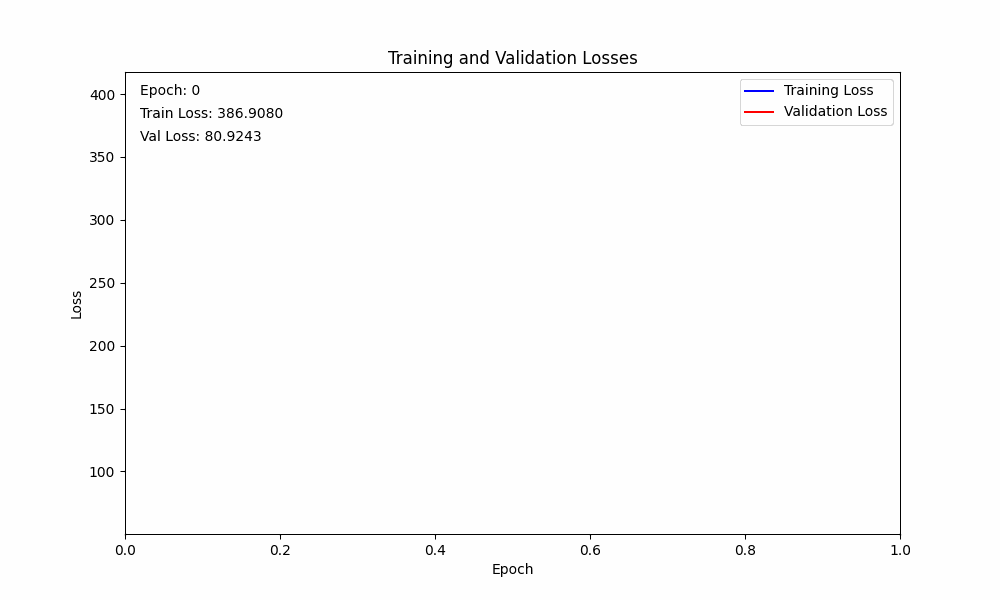

In [ ]:
# Now we perform training in a batching manner
epochs = 50
best_loss = float('inf')
best_model = None

train_loss_hist = []
val_loss_hist = []
frames = []

for epoch in range(epochs):
  net.train()
  train_losses = []
  for X, y in train_loader:
    if torch.cuda.is_available():
      X, y = X.cuda(), y.cuda() # Push data to cuda
    out = net(X)
    loss = loss_fn(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

  # Evaluate the model with the validation set
  val_losses = []
  net.eval() # Set model to evaluation mode
  with torch.no_grad():
    for X, y in val_loader:
      if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda() # Push data to cuda
      out = net(X)
      loss = loss_fn(out, y)
      val_losses.append(loss.item())

  avg_train_loss = np.mean(train_losses)
  avg_val_loss = np.mean(val_losses)
  train_loss_hist.append(avg_train_loss)
  val_loss_hist.append(avg_val_loss)
  frames.append(gif_utils.plot_losses(train_loss_hist, val_loss_hist, epoch))

  if avg_val_loss < best_loss:
    best_loss = avg_val_loss
    best_model = net.state_dict().copy()
    print(f"New best model at epoch {epoch} with training loss {avg_train_loss:.3f} and validation loss {best_loss:.3f}")

gif.save(frames, "mpg_mlp.gif", duration=1000)
display(Image(filename='mpg_mlp.gif'))

# Example of computation graph

In [ ]:
import graphviz
import gif
from IPython import display
import matplotlib.pyplot as plt
import torch

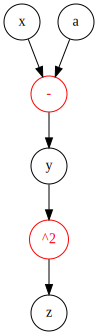

In [ ]:
# Example of computation graph for MSE loss

dot = graphviz.Digraph('DAG', comment='DAG')
dot.node('x', label='x', color='black', shape='circle')
dot.node('a', label='a', color='black', shape='circle')
dot.node('-', label='-', fontcolor='red', color='red', shape='circle')
dot.node('y', label='y', color='black', shape='circle')
dot.node('sq', label='^2', fontcolor='red', color='red', shape='circle')
dot.node('z', label='z', color='black', shape='circle')

dot.edge('x','-')
dot.edge('a','-')
dot.edge('-','y')
dot.edge('y','sq')
dot.edge('sq','z')

dot.render('dag_graph', view=True)

display.display(dot)
#print(dot.source)

Red nodes indicate mathematical operations while black nodes indicate tensors.

These types of computational graphs are called Directed Acyclic Graphs (DAGs)

Lets build this graph in PyTorch.

In [ ]:
# These tensors form the leaves. By default all subsequently generated intermediate tensors will have requires_grad=True
x = torch.tensor(0, dtype=torch.float32, requires_grad=True)
a = torch.tensor(5, dtype=torch.float32, requires_grad=True)
y = x - a
# By default pytorch wont retain the gradients of non leaf tensors.
y.retain_grad()
z = y.pow(2)
z.retain_grad()

# Now lets compute dz/dy, dz/dx and dz/da.
# We do this by calling the backward() on the root node which accumulates the
# gradients into all leaf nodes and non leaf tensors if retain_grad() is specified.
z.backward()

print(f'dz/dz = {z.grad}')
print('z = y^2')
print(f'dz/dy = {y.grad}')
print('y = x - a')
print(f'dz/da = (dz/dy)*(dy/da) = {a.grad}')
print(f'dz/dx = (dz/dy)*(dy/dx) = {x.grad}')

dz/dz = 1.0
z = y^2
dz/dy = -10.0
y = x - a
dz/da = (dz/dy)*(dy/da) = 10.0
dz/dx = (dz/dy)*(dy/dx) = -10.0


**Exercise 1: Build a computation graph in pytorch for $y = Sin(x_{1})*Cos(x_{2}) + e^{x_{3}}$ and compute $\frac{dy}{dx_{1}}$,$\frac{dy}{dx_{2}}$,$\frac{dy}{dx_{3}}$ given initial values of $x_{1}$, $x_{2}$ and $x_{3}$ as 1,2,3 respectively**


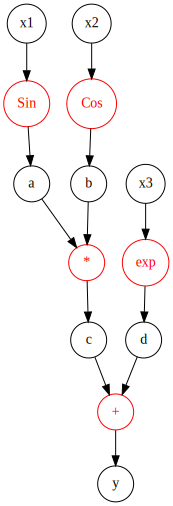

In [ ]:
# Example of computation graph for MSE loss

dot = graphviz.Digraph('DAG', comment='DAG')
dot.node('x1', label='x1', color='black', shape='circle')
dot.node('x2', label='x2', color='black', shape='circle')
dot.node('x3', label='x3', color='black', shape='circle')
dot.node('Sin', label='Sin', fontcolor='red', color='red', shape='circle')
dot.node('Cos', label='Cos', fontcolor='red', color='red', shape='circle')
dot.node('a', label='a', color='black', shape='circle')
dot.node('b', label='b', color='black', shape='circle')
dot.node('*', label='*', fontcolor='red', color='red', shape='circle')
dot.node('+', label='+', fontcolor='red', color='red', shape='circle')
dot.node('c', label='c', color='black', shape='circle')
dot.node('exp', label='exp', fontcolor='red', color='red', shape='circle')
dot.node('d', label='d', color='black', shape='circle')
dot.node('y', label='y', color='black', shape='circle')

dot.edge('x1','Sin')
dot.edge('x2','Cos')
dot.edge('Sin','a')
dot.edge('Cos','b')
dot.edge('a','*')
dot.edge('b','*')
dot.edge('*','c')
dot.edge('x3','exp')
dot.edge('exp','d')
dot.edge('d','+')
dot.edge('c','+')
dot.edge('+','y')

dot.render('dag_graph', view=True)

display.display(dot)
#print(dot.source)

In [ ]:
# Implementation in PyTorch

x1 = torch.tensor(1, dtype=torch.float32, requires_grad=True)
x2 = torch.tensor(2, dtype=torch.float32, requires_grad=True)
x3 = torch.tensor(3, dtype=torch.float32, requires_grad=True)

a = torch.sin(x1)
a.retain_grad()
b = torch.cos(x2)
b.retain_grad()

c = a*b
c.retain_grad()

d = torch.exp(x3)
d.retain_grad()

y = c + d

y.backward()


print(f'dy/dx1 = {x1.grad}')
print(f'dy/dx2 = {x2.grad}')
print(f'dy/dx3 = {x3.grad}')

dy/dx1 = -0.22484511137008667
dy/dx2 = -0.7651473879814148
dy/dx3 = 20.08553695678711


# 4. Gradient Descent

#Let's look how Gradient descent works inside pytorch.


**Gradient descent:**

An iterative optimization algorithm for finding the local minimum of a differentiable function.

$\theta_{t + 1} = \theta_{t} - \alpha * \nabla \mathcal{L}(\theta) $


$\theta_{t}$ is our initial guess

$\theta_{t+1}$ is our updated guess

$\alpha$ is the learning rate

$\nabla \mathcal{L}(\theta)$ is the derivative of the loss function wrt $\theta_{t}$



In [ ]:
!git clone https://github.com/BughdaryanAram/labeled_micrograd.git
!cd labeled_micrograd && pip install .

Cloning into 'labeled_micrograd'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 102 (delta 41), reused 43 (delta 41), pack-reused 39
Receiving objects: 100% (102/102), 239.91 KiB | 6.15 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Processing /content/labeled_micrograd
  Preparing metadata (setup.py) ... done
  Created wheel for micrograd: filename=micrograd-0.1.0-py3-none-any.whl size=5040 sha256=a97d161d70ef27090afc1eae4fb3ff80638f07602f06e315c9e6f073e5d33f61
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ftqs1lq/wheels/76/5d/c1/85554b593c51091a9b469ebffd35eb9321cb66b01be346323f
Successfully built micrograd
  Attempting uninstall: micrograd
    Found existing installation: micrograd 0.1.0
    Uninstalling micrograd-0.1.0:
      Successfully uninstalled micrograd-0.1.0


In [ ]:
from labeled_micrograd.micrograd.engine import Value

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

**Recall**: If we have a function  f(x, y) :

	•	If the derivative of  f  with respect to  x  is positive, then increasing  x  a little bit will cause  f  to increase.
	•	If the derivative of  f  with respect to  y  is negative, then increasing  y  will cause  f  to decrease.


Since we know that gradient descent is just an optimization algorithm. so we can optimize any function (differentable) we want. Let's manually minimze g =  1/2 * (2*(a + b + 1) + 1 + (w * a))

In [ ]:

# Step 1: Initialize the variables
W1 = Value(1, label='W1')
x1 = Value(-3, label='x1')

W2 = Value(2, label='W2')
x2 = Value(5, label='x2')

b = Value(6, label='b')

y_true = Value(-5, label='y_true')

W1x1 = W1 * x1
W1x1.label = 'W1*x1'

W2x2 = W2 * x2
W2x2.label = 'W2*x2'

w1x1w2x2 = W1x1 + W2x2
w1x1w2x2.label = 'W1x1+W2x2'

w1x1w2x2b = w1x1w2x2 + b
w1x1w2x2b.label = 'W1x1+W2x2+b'


y = w1x1w2x2b.relu()
y.label = 'y'

loss = y + y_true
loss.label = 'loss'

loss.backward()


print(f'{loss.data:.4f}')


8.0000


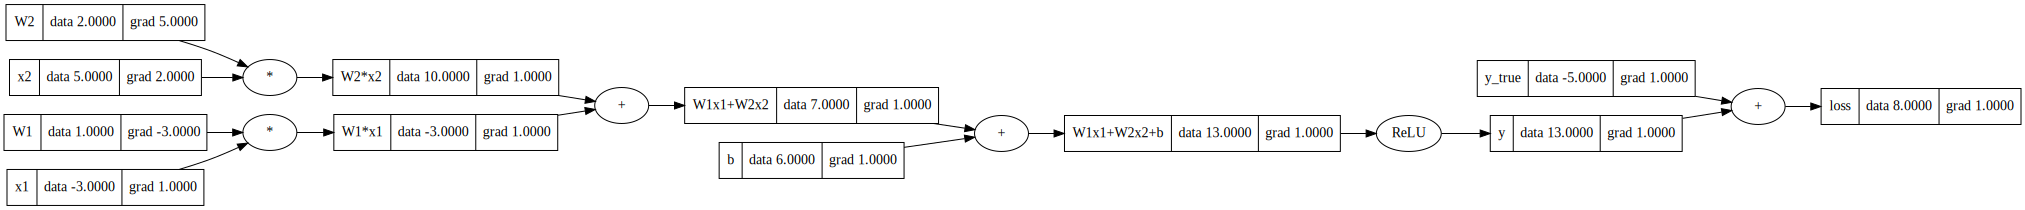

In [ ]:
draw_dot(loss)

**Exercise 0:** we can we change value of W2 (initially W2=2) so that the value of loss decrease?


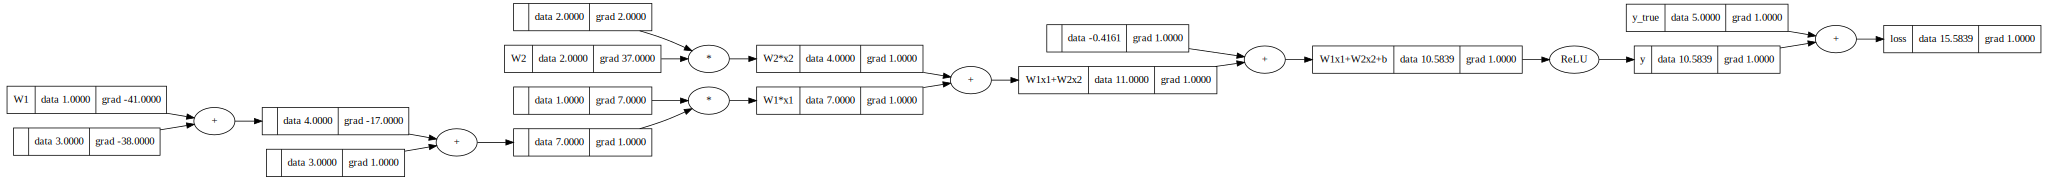

In [ ]:
# W1 = Value(1, label='W1')
# x1 = Value(3, label='x1')

# W2 = Value(2, label='W2')
# x2 = Value(5, label='x2')
# b = Value(6, label='b')

y_true = Value(5, label='y_true')

W1x1 = W1 * x1
W1x1.label = 'W1*x1'

W2x2 = W2 * x2
W2x2.label = 'W2*x2'

w1x1w2x2 = W1x1 + W2x2
w1x1w2x2.label = 'W1x1+W2x2'

w1x1w2x2b = w1x1w2x2 + b
w1x1w2x2b.label = 'W1x1+W2x2+b'


y = w1x1w2x2b.relu()
y.label = 'y'

loss = y + y_true
loss.label = 'loss'

loss.backward()

draw_dot(loss)

Now equipped with knowledge of how autograd works lets implement gradient descent.

Consider an extremely simplistic system:

Your data is one number and you want to guess that number. (You have access only to the gradient of the error.)

Lets define a function that will perform gradient descent for us.

In [ ]:
def gradient_descent(parameters, gradients, alpha=1.0):
    parameters -= gradients * alpha
    return parameters

Text(0, 0.5, '$\\mathcal{L}$')

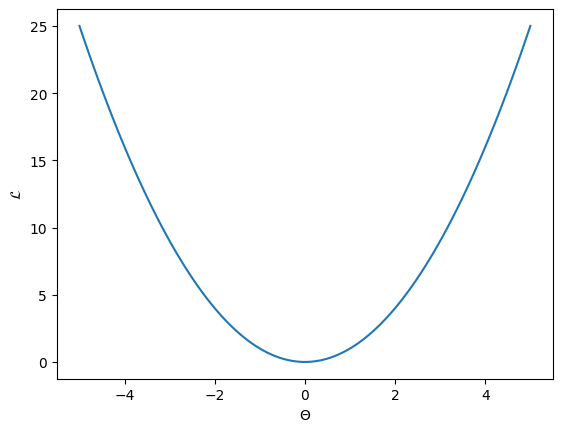

In [ ]:
import matplotlib.pyplot as plt
import gif

# Define the target value. The number you want to guess
x = torch.tensor(0.0)
# Define the loss function
loss_fn = torch.nn.MSELoss()
# Define the range of theta values. The predictions
theta_space = torch.linspace(-5.0, 5.0, 100)
# Plot
plt.plot(theta_space, [loss_fn(_theta, x) for _theta in theta_space])
plt.xlabel("$ \Theta $")
plt.ylabel("$\mathcal{L}$")

In [ ]:
theta = torch.tensor(5.0, requires_grad=True)
print(theta.item())

5.0


In [ ]:
# Define the target
x = torch.tensor(0.0)
# Define the loss
loss_fn = torch.nn.MSELoss()

# Start off with a random theta value. This is your initial guess. We will update this using gradient descent
theta = torch.tensor(5.0, requires_grad=True)

# Store all the updates to theta and the loss function in lists
theta_trajectory = []
loss_trajectory = []

for _ in range(100):

    x_hat = theta
    # Append the current theta value to the theta_trajectory list
    theta_trajectory.append(theta.item())
    # Calculate the MSE loss. This is also a tensor
    loss = loss_fn(x, x_hat)
    # Compute the gradient of loss wrt theta
    loss.backward()
    # We can access dL/dtheta using theta.grad
    gradients = theta.grad

    # Let pass the gradient to our gradient_descent function to get the updated value of theta
    with torch.no_grad():
        theta = gradient_descent(theta, gradients, alpha=0.001)
        # We need to zero the gradients, otherwise they will continue to get accumulated in the buffer (i.e they are not overwritten)
        theta.grad.zero_()

    # Append the current loss value to the loss_trajectory list
    loss_trajectory.append(loss.item())


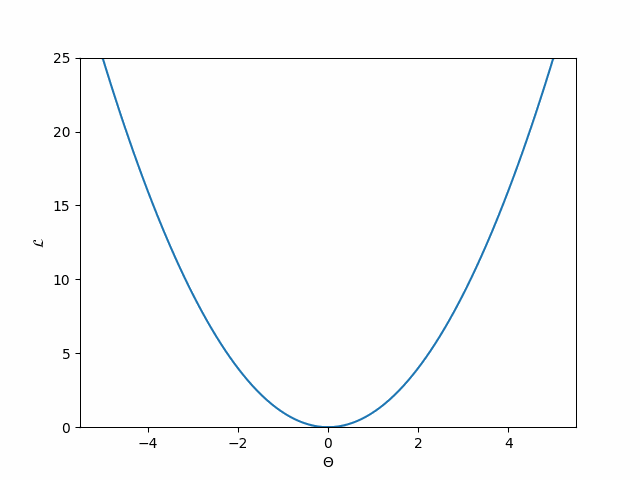

In [ ]:
@gif.frame
def step(i):
    x = torch.tensor(0.0)
    loss_fn = torch.nn.MSELoss()
    theta_space = torch.linspace(-5.0, 5.0, 100)
    plt.clf()
    plt.plot(theta_space, [loss_fn(_theta, x) for _theta in theta_space])
    plt.plot(theta_trajectory[:i], loss_trajectory[:i], '-o')
    plt.xlabel("$ \Theta $")
    plt.ylabel("$\mathcal{L}$")
    plt.ylim(0, 25)

frames = [step(i) for i in range(100)]
gif.save(frames, "gradient_descent.gif", duration=10)
file_handle = open("gradient_descent.gif", "rb")
display.Image(file_handle.read(), format="png")

**Exercise 2: What happens if you increase or decrease the learning rate ?**

## Train a neural net on MNIST-Fashion Dataset

In the previous example, we used gradient descent to estimate the true value. Now let’s use gradient descent to train neural networks that take an image of fashion items as input and predict the corresponding category.

**Step 1 : Download image dataset**

A portion of the dataset is used to train the machine learning model while the rest is kept aside as a test dataset which will be used to test how well the model performs on new data.

dataset_train and dataset_test are PyTorch dataset objects.

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

dataset_train = datasets.FashionMNIST("data", train=True, download=True, transform=ToTensor())
dataset_test = datasets.FashionMNIST("data", train=False, download=True, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:02<00:00, 8875041.91it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175203.42it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3262968.58it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21378492.07it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
# Different off the shelf datasets available on PyTorch
print(dir(datasets))

['CIFAR10', 'CIFAR100', 'CLEVRClassification', 'CREStereo', 'Caltech101', 'Caltech256', 'CarlaStereo', 'CelebA', 'Cityscapes', 'CocoCaptions', 'CocoDetection', 'Country211', 'DTD', 'DatasetFolder', 'EMNIST', 'ETH3DStereo', 'EuroSAT', 'FER2013', 'FGVCAircraft', 'FakeData', 'FallingThingsStereo', 'FashionMNIST', 'Flickr30k', 'Flickr8k', 'Flowers102', 'FlyingChairs', 'FlyingThings3D', 'Food101', 'GTSRB', 'HD1K', 'HMDB51', 'INaturalist', 'ImageFolder', 'ImageNet', 'Imagenette', 'InStereo2k', 'KMNIST', 'Kinetics', 'Kitti', 'Kitti2012Stereo', 'Kitti2015Stereo', 'KittiFlow', 'LFWPairs', 'LFWPeople', 'LSUN', 'LSUNClass', 'MNIST', 'Middlebury2014Stereo', 'MovingMNIST', 'Omniglot', 'OxfordIIITPet', 'PCAM', 'PhotoTour', 'Places365', 'QMNIST', 'RenderedSST2', 'SBDataset', 'SBU', 'SEMEION', 'STL10', 'SUN397', 'SVHN', 'SceneFlowStereo', 'Sintel', 'SintelStereo', 'StanfordCars', 'UCF101', 'USPS', 'VOCDetection', 'VOCSegmentation', 'VisionDataset', 'WIDERFace', '__all__', '__builtins__', '__cached__',

In [ ]:
print(f'Number of samples in train dataset : {len(dataset_train)}')
print(f'Number of samples in test dataset : {len(dataset_test)}')

Number of samples in train dataset : 60000
Number of samples in test dataset : 10000


In [ ]:
print(dir(dataset_train))
dataset_train.classes
dataset_train.data.shape

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']


torch.Size([60000, 28, 28])

## Labels

Each training and test example is assigned to one of the following labels:

| Label | Description  |
|-------|--------------|
| 0     | T-shirt/top  |
| 1     | Trouser      |
| 2     | Pullover     |
| 3     | Dress        |
| 4     | Coat         |
| 5     | Sandal       |
| 6     | Shirt        |
| 7     | Sneaker      |
| 8     | Bag          |
| 9     | Ankle boot   |



In [ ]:
dataset_train.data.shape

torch.Size([60000, 28, 28])

In [ ]:
plt.imshow(dataset_train[0][0][0])

NameError: name 'plt' is not defined

In [ ]:
dataset_train.targets[0]

tensor(9)

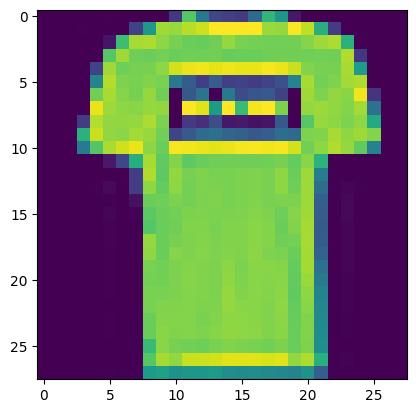

In [ ]:
plt.imshow(dataset_train[1][0][0])

In [ ]:
dataset_train.targets[0]

tensor(9)

In [ ]:
from torch.utils.data import DataLoader
loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, pin_memory=True)
loader_test = DataLoader(dataset_test, batch_size=64, shuffle=True, pin_memory=True)

**Creating own PyTorch Dataset**

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  # Create attributes for the CustomDataset class here
  def __init__(self, X):
    self.X = X

  # Optional. Returns the number of samples in the dataset
  def __len__(self):
    return X.shape[0]

  # Required. Should overwrite this method. This is how you fetch data from the dataset.
  def __getitem__(self, idx):
    return X[idx,:]


In [ ]:
# Lets start off with a dummy dataset with 100 samples and 10 features(inputs)
X = torch.randn((100, 10))

# Pass it into our custom PyTorch Dataset class to create out custom_dataset object.
custom_dataset = CustomDataset(X)

In [ ]:
# As before we can use the len() to find the number of samples in our dataset
len(custom_dataset)

100

In [ ]:
# We can now pass custom_dataset into our DataLoader to create an iterable over our PyTorch Dataset.
custom_dataloader = DataLoader(custom_dataset, batch_size=10, shuffle=True)

In [ ]:
# Now in our training and test loops we can easily access our batches.
for batch in custom_dataloader:
  # Just printing out the first batch here.
  print(batch.shape)
  break

torch.Size([10, 10])



**Step 3 : Define the neural net model**

For this we create a class called Model which subclasses the torch.nn.Module class.



In [ ]:
import torch
class Model(torch.nn.Module):

    # Define model layers here
    def __init__(self):
        super().__init__()
        self.fc0 = torch.nn.Linear(28*28, 16)
        self.fc1 = torch.nn.Linear(16, 16)
        self.fc2 = torch.nn.Linear(16, 10)

    # Define how the layers are connected here
    def forward(self, x):
        # Linear layers can only take 1D tensors as input so we need to flatten our images
        x = torch.nn.Flatten()(x)
        x = self.fc0(x)
        x = torch.nn.ReLU()(x)
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x

In [ ]:
# We can view the layers used to build the model by just calling print(model)
model = Model()
print(model)

Model(
  (fc0): Linear(in_features=784, out_features=16, bias=True)
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)


In [ ]:
# Model parameters can be accessed using the model.parameters() or model.named_parameters() function.
for parameter in model.named_parameters():
  layer_name, parameter_name = parameter[0].split('.')
  if parameter_name == 'weight':
    num_params = parameter[1].shape[0]*parameter[1].shape[1]
  else:
    num_params = parameter[1].shape[0]
  print(f'Layer {layer_name} {parameter_name} Shape : {parameter[1].shape} , Number of parameters :{num_params}')

Layer fc0 weight Shape : torch.Size([16, 784]) , Number of parameters :12544
Layer fc0 bias Shape : torch.Size([16]) , Number of parameters :16
Layer fc1 weight Shape : torch.Size([16, 16]) , Number of parameters :256
Layer fc1 bias Shape : torch.Size([16]) , Number of parameters :16
Layer fc2 weight Shape : torch.Size([10, 16]) , Number of parameters :160
Layer fc2 bias Shape : torch.Size([10]) , Number of parameters :10


Some more non linear activation functions

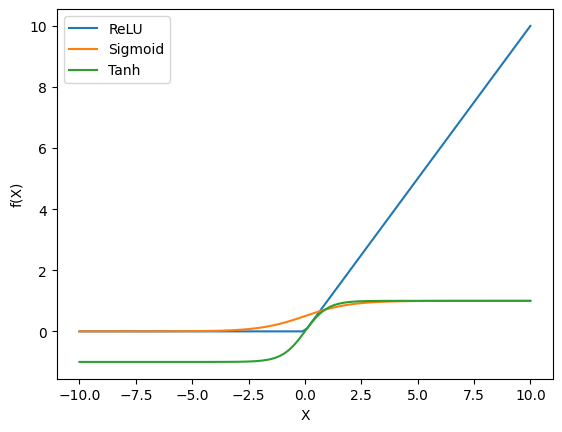

In [ ]:
import matplotlib.pyplot as plt
X = torch.linspace(-10,10,100)

def ReLU(X):
  return torch.clamp(X, min=0)

def sigmoid(X):
  return 1/(1 + torch.exp(-X))

def tanh(X):
  return (torch.exp(X) - torch.exp(-X))/(torch.exp(X) + torch.exp(-X))

plt.plot(X, ReLU(X), label='ReLU')
plt.plot(X, sigmoid(X), label='Sigmoid')
plt.plot(X, tanh(X), label='Tanh')
plt.ylabel('f(X)')
plt.xlabel('X')
plt.legend()
plt.show()

**Step 4 : Select optimization scheme to use**

For this example we will be using the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).



In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


**Step 5 : Select loss function to use**

$ L_{bce} = - (y_{1}*log(\hat y_{1}) + y_{2}*log(\hat y_{2})) $

* Useful for binary classification problems where we have just 2 classes.
* Here $y_{1}$ and $y_{2}$ are true probabilities that input belongs to class 1 and 2.
* $\hat y_{1}$ and $\hat y_{2}$ are model predicted probabilities that input belongs to class 1 and class 2.

$ L_{ce} = - \sum_{c=1}^{C} y_{c}*log(\hat y_{c})$

* This loss is used for multi class classification task (i.e when we have more than 2 classes)

$ L_{mse} = (y - \hat y)^2$

**Exercise 3 : Graph the behaviour of binary cross entropy and mean squeared error when target is equal to 1. Compare and contrast the plots. Which loss function makes more sense to be used in classification problems ?**

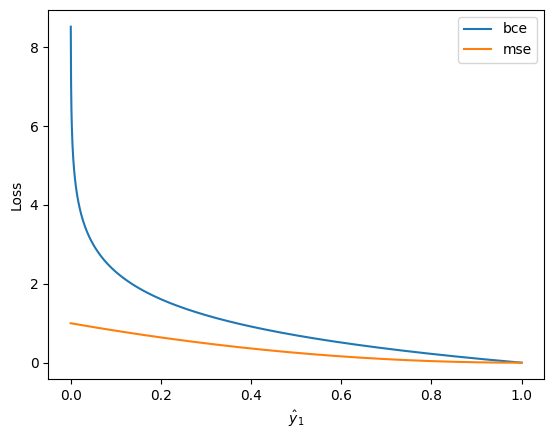

In [ ]:
# In Biary cross entropy we have just 2 classes.
# For a given input lets assume it belongs to class 1. Then y1=1 and y2=0
# Lets vary the model predicted probability for class 1 (y1_hat) from 0 to 1 and observe how the losses for both BCE and MSE vary.
y1_hat = torch.linspace(0,1,5000, dtype=torch.float32)

y1 = torch.ones(y1_hat.shape[0])

def bce(y1_hat, y1):
  # Since we have
  return -y1*torch.log(y1_hat)

def mse(y1_hat, y1):
  return (y1 - y1_hat)**2

plt.plot(y1_hat, bce(y1_hat, y1), label='bce')
plt.plot(y1_hat, mse(y1_hat, y1), label='mse')
plt.xlabel(r'$\hat y_{1}$')
plt.ylabel('Loss')
plt.legend()
plt.show()

Cross entropy loss is a better function to use for classification tasks as it gives a larger penalty (compare the blue and orange loss curves when $\hat y_{1}$ is close to 0) for wrong class prediction than compared to Mean squared error loss function.

In [ ]:
# Instatntiate the cross entropy loss
ce = torch.nn.CrossEntropyLoss()

**Step 5 : Train model**

In [ ]:
model = Model()

if torch.cuda.is_available():
    model = model.cuda()

import tqdm # To show progress bar

for _ in tqdm.tqdm(range(10)):

    for x, y in loader_train:

        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()

        y_hat = model(x)

        loss = ce(y_hat, y)

        loss.backward()

        optimizer.step()

100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


In [ ]:
for x,y in loader_train:
  x = x.to('cuda')
  y_hat = model(x)
  break

In [ ]:
y_hat.argmax(-1)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')

**Step 6 : Test model**

In [ ]:
# Calculate train accuracy
correct = 0
for x, y in loader_train:

    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()

    y_hat = model(x).argmax(-1)

    correct += (y_hat == y).sum().item()

accuracy_train = correct / len(loader_train.dataset)

# Calculate test accuracy
correct = 0
for x, y in loader_test:

    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()

    y_hat = model(x).argmax(-1)

    correct += (y_hat == y).sum().item()

accuracy_test = correct / len(loader_test.dataset)

print(f"Training accuracy {accuracy_train}, test accuracy {accuracy_test}.")

Training accuracy 0.09903333333333333, test accuracy 0.1011.


## Can we design a model with a better inductive bias?

The problem with flattening out the input image is we lose information on how pixels are spatially correlated with each other.

We can fix this problem by using a special type of layer called as [convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=convolutional+layer).


![ConvUrl](https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif "conv")


**Define array `a`:**

\[
a = \begin{bmatrix}
1 & 1 & 2 \\
0 & 1 & 3 \\
1 & 3 & 0 \\
4 & 5 & 2
\end{bmatrix}
\]

**Define array `b`:**

\[
b = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
\]

**Define function `f`:**

\[
f(x) = max(x_i)
\]

**Sample output of applying function `f` to an array:**

\
\begin{bmatrix}
1 & 3 \\
3 & 1 \\
5 & 3
\end{bmatrix}

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=5)
        self.fc = torch.nn.Linear(3 * 3 * 32, 10)

    def forward(self, x):
        # Typical Stacking method : Conv2D -> MaxPool2D/AvgPool2D (for downsampling) -> Non linear activation

        x = self.conv1(x)
        x = torch.nn.ReLU()(x)

        x = self.conv2(x)
        x = torch.nn.MaxPool2d(2)(x)
        x = torch.nn.ReLU()(x)

        x = self.conv3(x)
        x = torch.nn.MaxPool2d(2)(x)
        x = x.flatten(-3, -1)

        x = self.fc(x)

        return x

In [ ]:
model = Model()

if torch.cuda.is_available():
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), 1e-3)

import tqdm

for _ in tqdm.tqdm(range(10)):

    for x, y in loader_train:

        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()

        y_hat = model(x)

        loss = torch.nn.CrossEntropyLoss()(y_hat, y)

        loss.backward()

        optimizer.step()

100%|██████████| 10/10 [19:54<00:00, 119.48s/it]


In [ ]:
correct = 0
for x, y in loader_train:
    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
    y_hat = model(x).argmax(-1)
    correct += (y_hat == y).sum().item()
accuracy_train = correct / len(loader_train.dataset)

correct = 0
for x, y in loader_test:
    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
    y_hat = model(x).argmax(-1)
    correct += (y_hat == y).sum().item()
accuracy_test = correct / len(loader_test.dataset)

print(f"Training accuracy {accuracy_train}, test accuracy {accuracy_test}.")

Training accuracy 0.94745, test accuracy 0.9049.


**Exercise 4 : What happens when you increase the number of convolutional layers ? Does the accuracy increase or decrease ?**